In [1]:
#!/usr/bin/env python
# coding: utf-8


import numpy as np
import pandas as pd

import _pickle as cPickle
import argparse
from copy import deepcopy
import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
import time
from tqdm import tqdm

In [2]:
parser = argparse.ArgumentParser()
arg = parser.add_argument
arg('seed', type=int)
arg('train_file', type=str)
arg('test_file', type=str)
arg('--learning_rate', type=float, default=0.05)
arg('--num_leaves', type=int, default=31)
arg('--n_estimators', type=int, default=500)
args = parser.parse_args(args=['1','train_fe.ftr', 'test_fe.ftr'])

print(args)

Namespace(learning_rate=0.05, n_estimators=500, num_leaves=31, seed=1, test_file='test_fe.ftr', train_file='train_fe.ftr')


In [3]:
train_fe = pd.read_feather(f'../prepare_data/{args.train_file}')
test_fe = pd.read_feather(f'../prepare_data/{args.test_file}')

target_fe = train_fe['meter_reading']
train_fe = train_fe.drop('meter_reading', axis=1)

In [4]:
# drop_feature = ['day', 'hour', 'weekday', 'year_built_cat', 'wind_direction']
# df_dropped = df[drop_feature].copy()
# df = df.drop(drop_feature, axis=1)

X_train = train_fe.query('20160115 <= timestamp < 20160601 & site_id != 0')
X_valid = train_fe.query('20160901 <= timestamp < 20170101 & site_id != 0')
X_test = test_fe

y_train = target_fe.loc[X_train.index]
y_valid = target_fe.loc[X_valid.index]
# y_train = np.log1p(y_train)
# y_valid = np.log1p(y_valid)

X_train = X_train.drop('timestamp', axis=1)
X_valid = X_valid.drop('timestamp', axis=1)
X_test = X_test.drop('timestamp', axis=1)

# print(X_train.shape)

In [5]:
def meter_fit(meter, X_train, X_valid, y_train, y_valid, n_estimators=20000, verbose=5000, random_state=823, **params):
    model = lgb.LGBMRegressor(random_state=random_state, n_estimators=n_estimators, n_jobs=4, metric='rmse', **params)

    X_train_m = X_train.query('meter == {}'.format(meter)).drop('meter', axis=1)
    X_valid_m = X_valid.query('meter == {}'.format(meter)).drop('meter', axis=1)
    y_train_m = y_train[X_train_m.index]
    y_valid_m = y_valid[X_valid_m.index]
    
    g = X_valid_m.groupby('building_id')
    eval_names = ['train', 'valid']
    eval_set = [(X_train_m, y_train_m), (X_valid_m, y_valid_m)]
#     print(sorted(X_valid_m['building_id'].unique()))
    for i in tqdm(sorted(X_valid_m['building_id'].unique())):
        set_evalX = g.get_group(i)
        eval_set.append((set_evalX, y_valid_m.loc[set_evalX.index]))
        eval_names.append(i)

# building_idを抜いて実験する場合
#     for X, y in eval_set:
#         del X['building_id']
        
#     print(X_train_m.shape)
    
    model.fit(X_train_m, y_train_m , eval_set = eval_set,#[(X_train_m, y_train_m), (X_valid_m, y_valid_m)], 
                    eval_names=eval_names, verbose=verbose)#, early_stopping_rounds = 100)
    return model


def meter_fit_all(meter, X_train, y_train, n_estimators, random_state=823, **params):
#     print(n_estimators)
    X_train_m = X_train.query('meter == {}'.format(meter)).drop('meter', axis=1)
    y_train_m = y_train[X_train_m.index]
    
    print("meter{}".format(meter), end='')
    model = lgb.LGBMRegressor(random_state=random_state, n_estimators=n_estimators, n_jobs=4, metric='rmse', **params)
    model.fit(X_train_m,y_train_m,
             eval_set = [(X_train_m, y_train_m)], 
                    verbose=10000)
    print(' done')
    return model

In [6]:
lgb_params = {
#                     'boosting_type':'gbdt',
                    'learning_rate':args.learning_rate, 
                    'num_leaves': args.num_leaves,
#                     'max_depth':-1,
                    'colsample_bytree': 0.8,
                    'subsample_freq':1,
                    'subsample':0.8,
                }

In [7]:
# meter type毎に訓練
models = dict()
for i in [3,2,1,0]:
    print('meter {} start at {}'.format(i,time.ctime()))
    models[i] = meter_fit(i, X_train, X_valid, y_train, y_valid, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)
    
# # rmseの計算
# meter_counts = X_valid['meter'].value_counts()
# mse_score = 0
# for i in [0,1,2,3]:
#     mse_score += meter_counts[i] * (models[i].best_score_['valid']['rmse'] ** 2)
# print('total rmse = {}'.format(np.sqrt(mse_score / meter_counts.sum())))

meter 3 start at Mon Jan 13 16:08:27 2020


100%|██████████| 142/142 [00:00<00:00, 350.01it/s]


(423155, 27)
meter 2 start at Mon Jan 13 16:08:44 2020


100%|██████████| 324/324 [00:00<00:00, 344.57it/s]


(926869, 27)
meter 1 start at Mon Jan 13 16:09:22 2020


100%|██████████| 474/474 [00:01<00:00, 381.97it/s]


(1306477, 27)
meter 0 start at Mon Jan 13 16:10:16 2020


100%|██████████| 1302/1302 [00:03<00:00, 377.17it/s]


(3972529, 27)
total rmse = 0.9055532007919442


In [8]:
# save model

save_name = '../model/model_use_{}_seed{}_leave{}_lr{}.pkl'.format(args.train_file.replace('.ftr', ''),args.seed, args.num_leaves, str(args.learning_rate).replace('.', ''))
with open(save_name, 'wb') as f:
    pickle.dump(models, f)

In [9]:
# 各building, meter毎の最良のiteration数
best_iteration = dict()
for meter in [0,1,2,3]:
    best_iteration[meter] = dict()
#     for i in range(1448):
#         best_iteration[meter][i] = 200
    for i in tqdm(sorted(X_valid.query('meter == {}'.format(meter))['building_id'].unique())):
        best_iteration[meter][i] = max(20, np.argmin(np.array(models[meter].evals_result_[i]['rmse'])) + 1)
#         best_iteration[meter][i] = np.argmin(np.array(models[meter].evals_result_[i]['rmse'])) + 1

100%|██████████| 142/142 [00:00<00:00, 16132.38it/s]


total rmse = 0.8246214572204994
{0: 0.38341327907541173, 1: 1.129476359756825, 2: 1.1633479876993276, 3: 1.538544389057388}
meter0 best_valid_iteration=290
meter0 best_valid_score=1.4293735361286997
meter1 best_valid_iteration=138
meter1 best_valid_score=2.209060103218956
meter2 best_valid_iteration=146
meter2 best_valid_score=2.2890135516877868
meter3 best_valid_iteration=208
meter3 best_valid_score=2.675532790285684


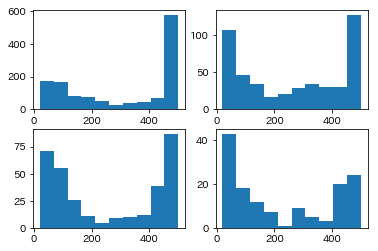

In [10]:
# best_scores = dict()
# for meter in [0,1,2,3]:
#     best_scores[meter] = 0
#     meter_size = X_valid.query('meter=={}'.format(meter)).groupby('building_id').size()
#     meter_size = meter_size[meter_size!=0]
#     for buildingID, cnt in meter_size.items():
#         best_scores[meter] += cnt * (min(models[meter].evals_result_[buildingID]['rmse']) ** 2)
#     best_scores[meter] = np.sqrt(best_scores[meter] / meter_size.sum())
    

# # rmseの計算
# meter_counts = X_valid['meter'].value_counts()
# mse_score = 0
# for i in [0,1,2,3]:
#     mse_score += meter_counts[i] * (best_scores[i] ** 2)
# print('total rmse = {}'.format(np.sqrt(mse_score / meter_counts.sum())))
# print(best_scores)
# for meter in [0,1,2,3]:
#     print('meter{} best_valid_iteration={}'.format(meter,np.argmin(np.array(models[meter].evals_result_['valid']['rmse']))+1))
#     print('meter{} best_valid_score={}'.format(meter,np.min(np.array(models[meter].evals_result_['valid']['rmse'])+1)))
#     plt.subplot(2,2,meter+1)
#     plt.hist(best_iteration[meter].values())
# plt.show()

In [11]:
del_list = [list(), list(), list(), list()]
for meter in [0,1,2,3]:
    for buildingID, itr in best_iteration[meter].items():
        if itr<=20:
            del_list[meter].append(buildingID)
        if itr<=100:
            best_iteration[meter][buildingID] = 100
#         if itr>=int(models[0].n_estimators * 0.98):
#             best_iteration[meter][buildingID] = models[0].n_estimators
            
new_train_fe = train_fe.copy()
new_train_fe['meter_reading'] = target_fe
for meter in [0,1,2,3]:
    new_train_fe = new_train_fe.query('~(meter=={} & building_id == {} & timestamp<20160601)'.format(meter, del_list[meter]))

new_target = new_train_fe['meter_reading']
new_train_fe = new_train_fe.drop('meter_reading', axis=1)

In [12]:
for meter in [0,1,2,3]:
    for i in range(1448):
        if i not in best_iteration[meter]:
            best_iteration[meter][i] = 200

In [13]:
# meter type毎に訓練(全てのデータを使う)
models_all = dict()
for i in [3, 2, 1, 0]:
    print('meter {} start at {}'.format(i,time.ctime()))
    models_all[i] = meter_fit_all(i, new_train_fe.drop('timestamp', axis=1), new_target, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)
#     models_all[i] = meter_fit_all(i, train_fe.drop('timestamp', axis=1), target_fe, random_state=args.seed, n_estimators=args.n_estimators, **lgb_params)

meter 3 start at Mon Jan 13 16:13:29 2020
500
meter3 done
meter 2 start at Mon Jan 13 16:13:50 2020
500
meter2 done
meter 1 start at Mon Jan 13 16:14:37 2020
500
meter1 done
meter 0 start at Mon Jan 13 16:15:51 2020
500
meter0 done


In [14]:
#save model

save_name = '../model/model_all_use_{}_seed{}_leave{}_lr{}.pkl'.format(args.train_file.replace('.ftr', ''),args.seed, args.num_leaves, str(args.learning_rate).replace('.', ''))
with open(save_name, 'wb') as f:
    pickle.dump(models_all, f)